In [1]:
#data manipulation packages
import pandas as pd
import numpy as np
import scipy
import re

#visualization tools
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

In this notebook, we wil be visualizing some of the volatility and strength properties of items and categories. This will help us detect outliers and feature engineer based on strength of trend, volatility of trend, and otherwise.

In [36]:
cal = pd.read_csv('calendar.csv', parse_dates = ['date'])
sales = pd.read_csv('sales_train_validation.csv')
prices = pd.read_csv('sell_prices.csv')

In [4]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,...,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,...,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


Melting our 'Sales' data will allow us to easily insert the values from the following functions we make. The melted df was created in the EDA notebook, and will be read in as 'stv'.

We are going to split our data by year and state category so our feature engineering in the following cells are more manageable.

In [4]:
## grabbing just over the last two years of the data
stv = pd.read_pickle('grid_df.pkl')
stv['day'] = stv['d'].str.replace('d_','').astype(int)
short = stv.loc[stv['day']>1200]
short.shape

(22116579, 11)

Given the amount of computation it takes to generate the following time-series features, we will split the data by state category. 

In [5]:
short.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk,day
24765098,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1201,0.0,224,11415,1201
24765099,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1201,0.0,20,11415,1201
24765100,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1201,0.0,300,11415,1201
24765101,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1201,2.0,5,11415,1201
24765102,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1201,2.0,16,11415,1201


In [6]:
#splitting the data by state.
ca_short = short.loc[short['state_id']=='CA'][['id','d','cat_id','sales','day']]
tx_short = short.loc[short['state_id']=='TX'][['id','d','sales']]
wi_short = short.loc[short['state_id']=='WI'][['id','d','sales']]

In [2]:
## for quick access in case we need to restart the notebook.
short = pd.read_pickle('short.pkl')
ca_short = pd.read_pickle('ca_short.pkl')
tx_short = pd.read_pickle('tx_short.pkl')
wi_short = pd.read_pickle('wi_short.pkl')

In [4]:
# short.bollinger.fillna(method='ffill', inplace=True)
# short['cat'] = short['id'].str.split('_').str.get(0)

Let's index on an active item, and gather all of the 'd' columns to apply to all of our following functions

In [3]:
item = 'FOODS_3_090_CA_3_validation'
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
d_cols = [col for col in sales.columns if 'd_' in col]

NameError: name 'sales' is not defined

In case we need it, below we will create a feature that plots the sales of an item by day, month and year.

In [13]:
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
d_cols = [col for col in sales.columns if 'd_' in col]

def plot_item(item_id):
    '''Plot the selling history of "item" by day, month, and year.
    
    Args:
        item(str): id of the item we are wanting to plot.
    
    Returns:
        matplotlib plot object of item sale history
    '''
    global item
    item = 'FOODS_3_090_CA_3_validation'
    
    item_df = sales.loc[sales['id'] == item_id][d_cols].T
    item_df = item_df.rename(columns={sales.index[sales['id']==item_id].to_list()[0]:item_id}) # Name it correctly
    item_df = item_df.reset_index().rename(columns={'index': 'd'}) # make the index "d"
    item_df = item_df.merge(cal, how='left', validate='1:1')

    fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
    item_df[['date', item_id]].set_index('date').resample('D').mean()[item_id].plot(ax=axes, label='By day', alpha=0.8).set_ylabel('Amount of Item Sold', fontsize=14);
    item_df[['date', item_id]].set_index('date').resample('M').mean()[item_id].plot(ax=axes, label='By month', alpha=1).set_ylabel('Amount of Item Sold', fontsize=14);
    item_df[['date', item_id]].set_index('date').resample('Y').mean()[item_id].plot(ax=axes, label='By year', alpha=1).set_ylabel('Amount of Item Sold', fontsize=14);
    axes.set_title('Mean '+str(item_id)+ ' sold by hour, day and month', fontsize=16);
    axes.legend()

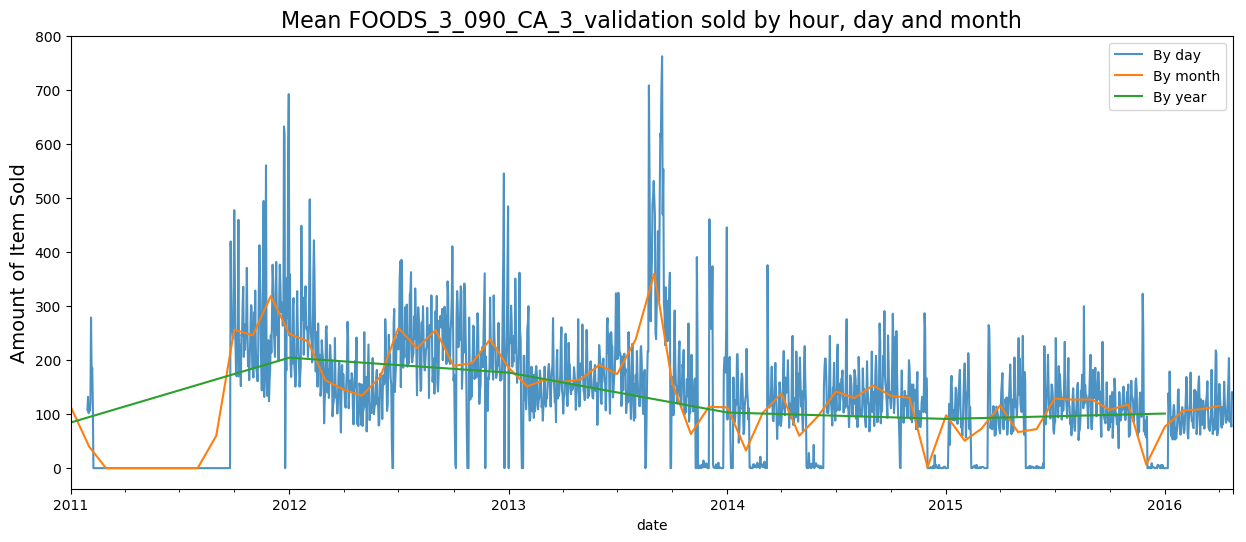

In [14]:
plot_item(item)

One way to detect outliers is through the use of bollinger bands - bands two standard deviations above and below the item's window mean. Those that are outside the bands will be deamed outliers.

In [6]:
def plot_bollinger_bands(item):
    '''bollinger bands around the 50-day rolling mean items sold per day for specified item.
    Args:
        item(str): id of the item we are wanting to plot.
    
    Returns:
        line plot of item sale history as well as 50-day rolling standard deviation of the time series (2):
    '''
    item_df = sales.loc[sales['id'] == item][d_cols].T
    item_df = item_df.rename(columns={sales.index[sales['id']==item].to_list()[0]:item}) # Name it correctly
    item_df = item_df.reset_index().rename(columns={'index': 'd'}) # make the index "d"
    item_df['mean'] = item_df[item].rolling(window=50).mean()
    item_df['std'] = item_df[item].rolling(window=50).std()
    item_df['upper_band'] = item_df['mean'] + (item_df['std'] * 2)
    item_df['lower_band'] = item_df['mean'] - (item_df['std'] * 2)
    
    item_df[[item, 'mean', 'upper_band', 'lower_band']].plot(figsize=(12,6))
    plt.grid(linestyle='-', linewidth='1')
    plt.title('30 Day Bollinger Band for {}'.format(item))
    plt.ylabel('Items Sold')
    plt.show()

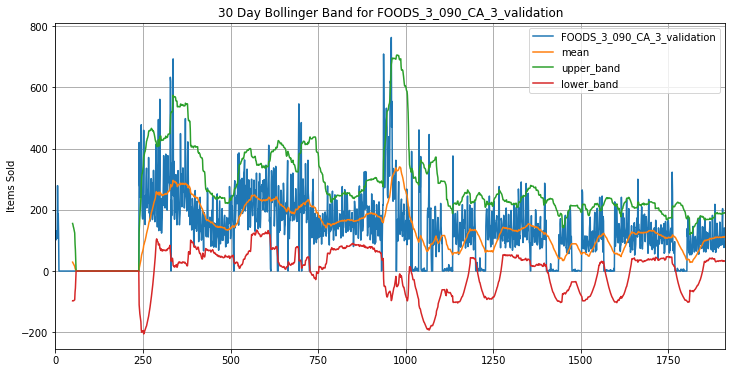

In [7]:
plot_bollinger_bands(item)

Before we apply our bollinger to remove outliers, lets identify all event days and make sure that we don't change values on those days since they are exceptional.

In [6]:
event_list=[i for i in cal.event_name_1.fillna(0).unique() if i != 0] 

#Extract all the days an event has in the span of 1916 days
day_event_list=[cal[cal.event_name_1==i].d.tolist() for i in event_list]

#Create the Event_df dataframe which we will use throughout the notebook
event_df=pd.DataFrame({'Event Name' : event_list, 'Event day':day_event_list})
restricted_day= set(['d_'+ str(i) for i in np.arange(1916,1970)])
quantity=[]

for i in day_event_list:
    # Making sure that we exclude all the days thats are not in the training set
    clean_i=list(set(i)-restricted_day)
    temp=sales[clean_i].sum().sum() #Adding columns and then rows
    quantity.append(temp)

event_df['Quantity']=quantity

all_events = event_df['Event day'].values
all_events = np.concatenate(all_events, axis=0)
all_events = all_events.astype(str)

In [7]:
def bollingers(item):
    '''bollinger bands around the 50-day rolling mean items sold per day for specified item.
    Args:
        item(str): id of the item we are wanting to plot.
    
    Returns:
        line plot of item sale history as well as 50-day rolling standard deviation of the time series (2):
    '''
    item_df = pd.DataFrame(short.loc[short['id'] == item][['d','sales']])
    item_df['mean'] = item_df['sales'].rolling(window=50).mean()
    item_df['std'] = item_df['sales'].rolling(window=50).std()
    item_df['upper_band'] = item_df['mean'] + (item_df['std'] * 2)
    item_df['lower_band'] = item_df['mean'] - (item_df['std'] * 2)
   
    #lets eliminate any outliers by finding values outside of the bands that are not on event days
    item_df['sales'] = np.where(
    (item_df['sales'] > item_df['upper_band']) & (item_df['d'].values not in all_events),
    item_df['upper_band'], item_df['sales'])
    item_df['sales'] = np.where(
    (item_df['sales'] < item_df['lower_band']) & (item_df['d'].values not in all_events),
    item_df['lower_band'], item_df['sales'])
        
    return np.floor(item_df['sales'].values)

In order to efficiently generate features, we will only consider the last 2+ years of the data set. That should be enough data to efficiently engineer features and not compromise predictive power. We will pickle our results.

In [18]:
epic = True
while epic==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==[item], 'bollinger'] = bollingers([item])
    epic = False

In [20]:
ca_short.to_pickle('ca_short.pkl')

In [21]:
epic1 = True
while epic1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==[item], 'bollinger'] = bollingers([item])
    epic1 = False

In [23]:
tx_short.to_pickle('tx_short.pkl')

In [8]:
epic2 = True
while epic2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==[item], 'bollinger'] = bollingers([item])
    epic2 = False

In [12]:
wi_short.to_pickle('wi_short.pkl')

In [6]:
short['cat'] = short['id'].str.split('_').str.get(0)
ca_short['cat'] = ca_short['id'].str.split('_').str.get(0)
tx_short['cat'] = tx_short['id'].str.split('_').str.get(0)
wi_short['cat'] = wi_short['id'].str.split('_').str.get(0)

Another metric we can plot out is the item's relative strength, which shows how well the item is selling within its window. Relative strength is the percentage of days that experienced higher selling than the previous day to the percentage of that experience lower selling than the previous day.

In [7]:
def plot_RSI(item, window, category=False):
    '''Relative strength of specified item compared to the average relative strength of all items in its category.
    
    Args:
        item(str): id of the item we are wanting to plot.
        window(int): number of days we want to average over.
        category(bool): whether or not we are finding the RS of an item or a category.
    
    Returns:
        Relative strength of item or category.
    '''
    if category == True:
        category = sales.loc[sales['id']==item]['cat_id']
        series = sales.loc[sales['cat_id'].isin(category)][d_cols].mean(axis=0).T
    else:
        series = sales.loc[sales['id'] == item][d_cols].T
    
    # Get the difference in price from previous step
    delta = series.diff().dropna()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = up.ewm(span=window).mean()
    roll_down1 = down.abs().ewm(span=window).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(window).mean()
    roll_down2 = down.abs().rolling(window).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    # Compare graphically
    fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
    RSI1.plot(ax=axes, label='EWMA of Item Sold', alpha=0.8).set_ylabel('RS Index', fontsize=14)
    RSI2.plot(ax=axes, label='SMA of Item Sold', alpha=0.8).set_ylabel('RSI Index', fontsize=14)
    axes.set_title('Relative Strength (using EWMA and SMA) of Item', fontsize=16);
    axes.grid(linestyle='-', linewidth='1')
    axes.legend(['RSI via EWMA', 'RSI via SMA'])

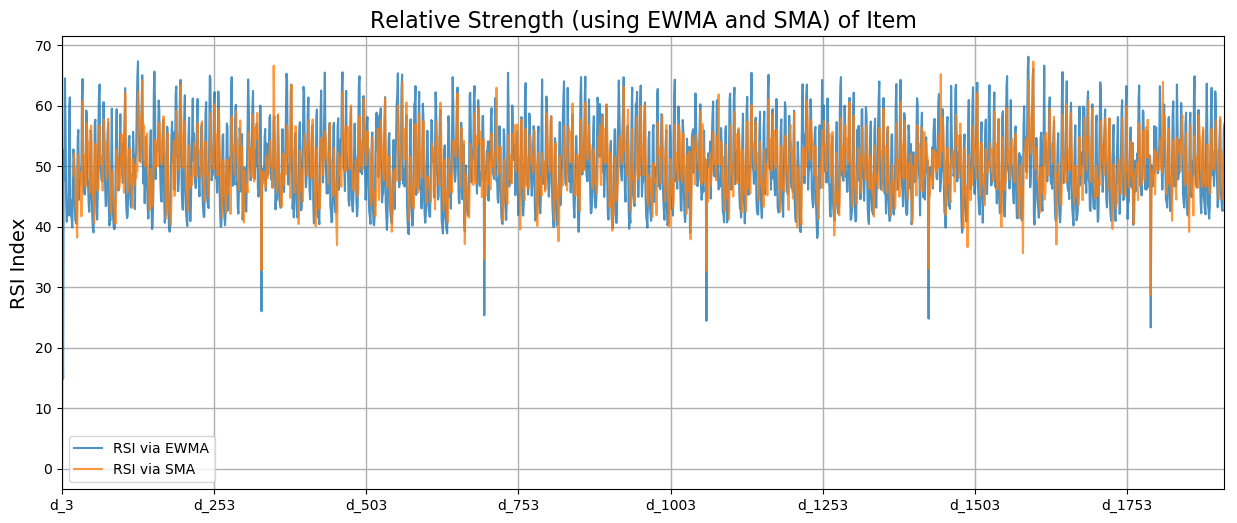

In [667]:
plot_RSI(item, 20, category=True)

In [3]:
def RS(item, window, category=False):
    '''Relative strength of specified item compared to the average relative strength of all items in its category.
    
    Args:
        item(str): id of the item we are wanting to plot.
        window(int): number of days we want to average over.
        category(bool): whether or not we are finding the RS of an item or a category.
    
    Returns:
        Relative strength of item or category.
    '''

    series = pd.DataFrame(short.loc[short['id'] == item]['bollinger'])
    
    # Get the difference in price from previous step
    delta = series.diff().dropna()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences
    delta = delta[1:] 
    
    #Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = up.ewm(span=window).mean()
    roll_down1 = down.abs().ewm(span=window).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    series['RS'] = RS1
#     RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
#     roll_up2 = up.rolling(window).mean()
#     roll_down2 = down.abs().rolling(window).mean()

#     # Calculate the RSI based on SMA
#     RS2 = roll_up2 / roll_down2
#     RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    return series['RS']


In [6]:
epic = True
while epic==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==item, 'RS'] = RS(item, 90)
    epic = False

In [7]:
ca_short.to_pickle('ca_rsi.pkl')

In [8]:
epic1 = True
while epic1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==item, 'RS'] = RS(item,90)
    epic1 = False

In [9]:
tx_short.to_pickle('tx_rsi.pkl')

In [10]:
epic2 = True
while epic2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==item, 'RS'] = RS(item,90)
    epic2 = False

Next, we will generate a inverse fisher transform oscillator using RSI instead of RS.From this, we can identify statistically uncommon sales amounts.

In [8]:
import finta as ta

def RSI2(series, period, adjust: bool = True):
    """Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    ## get the price diff
    delta = series.iloc[:,0].diff()

    ## positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # EMAs of ups and downs
    _gain = up.ewm(span=period, adjust=adjust).mean()
    _loss = down.abs().ewm(span=period, adjust=adjust).mean()

    RS = _gain / _loss
    return pd.Series((100 - (100 / (1 + RS))))


    
def inverse_fisher(item, rsi_period, wma_period):
    """Modified Inverse Fisher Transform applied on RSI.
    Suggested method to use any IFT indicator is to buy when the indicator crosses over –0.5 or crosses over +0.5
    if it has not previously crossed over –0.5 and to sell short when the indicators crosses under +0.5 or crosses under –0.5
    if it has not previously crossed under +0.5."""
    
    series = np.squeeze(sales.loc[sales['id'] == item][d_cols].T, axis=0)
    
    v1 = pd.Series(0.1 * (RSI2(series, rsi_period) - 50), name="v1")

    ### v2 = WMA(wma_period) of v1
    d = (wma_period * (wma_period + 1)) / 2  # denominator
    rev = v1.iloc[::-1]  # reverse the series
    wma = []

    def _chunks(series, period):  # split into chunks of n elements
        for i in enumerate(series):
            c = rev.iloc[i[0] : i[0] + period]
            if len(c) != period:
                yield None
            else:
                yield c

    def _wma(chunk, period):  # calculate wma for each chunk
        w = []
        for price, i in zip(chunk.iloc[::-1].items(), range(period + 1)[1:]):
            w.append(price[1] * i / d)
        return sum(w)

    for i in _chunks(rev, wma_period):
        try:
            wma.append(_wma(i, wma_period))
        except:
            wma.append(None)

    wma.reverse()  ##reverse the wma list t
#     ifish=(np.exp(2*v2)-1)/(np.exp(2*v2)+1)
    v1["v2"] = pd.Series(wma, index=v1.index)
    fish = pd.Series(
        ((2 * v1["v2"]) - 1) ** 2 / ((2 * v1["v2"]) + 1) ** 2, name="IFT_RSI"
    )
    return fish

To get really familiar with the items' properties, we can plot a Relative Rotation Graph. This locates the an item's relative strength and momentum from one period to another, and is compared to those properties of the benchmark (item's category aggregated stats). The direction of the property is important; each quadrant illustrates if the item's selling history is leading, lagging, weakening, or improving. The ideal formation is that the item's relative strength and momentum are both above 100, and is heading in the direction of the leading quadrant. The graph created below should help clarify.

In [9]:
def plot_RRG(item_cat, window):
    '''Relative Rotation Graph (RRG) of a sample of items and its categories. RRGs are made 
    of an item's/category's relative strength and momentum.
    
    Args:
        item(str): id of the item we are wanting to plot.
        window(int): window to to roll over.
    
    Returns:
        RRG of item nad it's category. This RRG takes advantage of a simple moving average.
    '''
    colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    category = sales.loc[sales['id']==item_cat]['cat_id']
    benchmark = sales.loc[sales['cat_id'].isin(category)][d_cols].mean(axis=0).T
    benchmark = pd.DataFrame({'mean_values':benchmark.values})
    
    
    # Get the difference in price from previous step
    benchmark_delta = benchmark.diff().dropna()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences  
    benchmark_delta = benchmark_delta[1:]
    # Make the positive gains (up) and negative gains (down) Series
    b_up, b_down = benchmark_delta.copy(), benchmark_delta.copy()
    b_up[b_up < 0] = 0
    b_down[b_down > 0] = 0
    
    #Calculate SMA
    b_roll_up2 = b_up.rolling(window).mean()
    b_roll_down2 = b_down.abs().rolling(window).mean()  

    b_RS2 = b_roll_up2 / b_roll_down2
#     b_RSI2 = 100.0 - (100.0 / (1.0 + b_RS2))
    benchmark['jdk_rs'] = 100 + ((b_RS2 - b_RS2.mean()) / b_RS2.std() + 1)
    
    b_mom = benchmark.iloc[:,0].diff(periods = window)
    benchmark['jdk_mom'] = 100 + ((b_mom - b_mom.mean()) / b_mom.std() + 1)
    
    
    #Repeat steps for a sample of items in that category
#     series_sample = sales.loc[sales['cat_id'].isin(category)]['id'].sample(sample)#grab sample of items
    
    series = sales.loc[sales['id'] == item][d_cols].T

    # Get the difference in price from previous step
    item_delta = series.diff().dropna()

    item_delta = item_delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    i_up, i_down = item_delta.copy(), item_delta.copy()
    i_up[i_up < 0] = 0
    i_down[i_down > 0] = 0

    # Calculate the EWMA
#     roll_up1 = up.ewm(span=window).mean()
#     roll_down1 = down.abs().ewm(span=window).mean()

#     # Calculate the RSI based on EWMA
#     RS1 = roll_up1 / roll_down1
#     RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    i_roll_up2 = i_up.rolling(window).mean()
    i_roll_down2 = i_down.abs().rolling(window).mean()

    # Calculate the RSI based on SMA
    i_RS2 = i_roll_up2 / i_roll_down2
#     i_RSI2 = 100.0 - (100.0 / (1.0 + i_RS2))
    series['jdk_rs'] = 100 + ((i_RS2 - i_RS2.mean()) / i_RS2.std() + 1)

    i_mom = series.iloc[:,0].diff(periods = window)

    series['jdk_mom'] = 100 + ((i_mom - i_mom.mean()) / i_mom.std() + 1)
    
    from scipy.interpolate import interp1d
    from matplotlib.patches import ConnectionPatch, FancyArrowPatch
    
    ix = series.iloc[::220]['jdk_rs'].values
    iy = series.iloc[::220]["jdk_mom"].values
    
    bx = benchmark.iloc[::150, benchmark.columns.get_loc("jdk_rs")].values
    by = benchmark.iloc[::150, benchmark.columns.get_loc("jdk_mom")].values
    
    improving_lagging = np.linspace(94,       
                     100, 
                     1000)
    leading_weaking = np.linspace(100,       
                     106, 
                     1000)

    
    b_origin=(bx[-2],by[-2])
    bxy =(bx[-1],by[-1])
    
    i_origin=(ix[-2],iy[-2])
    ixy =(ix[-1],iy[-1])
    

    #plotting RRG in steps of 150 days
    fig, axes = plt.subplots(1,1, figsize=(25,10), dpi=100)
    plt.scatter(bx,by, marker='o', label='Benchmark', color='red')
    plt.scatter(ix,iy, marker='o', label = 'Item', color=next(colors))
    axes.set_axisbelow(True)
    axes.grid(linestyle='-', linewidth='2.0')
    plt.xlim(95,105)
    plt.ylim(95,105)
    plt.axhline(100, linewidth=4, color='b')  #horizontal line
    plt.axvline(100, linewidth=4, color='b')
    plt.gca().fill_between(improving_lagging, 
                           100, 
                           106.5, 
                           alpha=0.1, color='b', zorder=3, label='Improving')
    plt.gca().fill_between(leading_weaking, 
                           100, 
                           106.5, 
                           alpha=0.1, color='g', zorder=4, label='Leading')
    plt.gca().fill_between(leading_weaking, 
                           94, 
                           100, 
                           alpha=0.1, color='y', zorder=5, label='Weakening')
    plt.gca().fill_between(improving_lagging, 
                           94, 
                           100, 
                           alpha=0.1, color='r', zorder=6, label='Lagging')
    plt.quiver(b_origin[0], b_origin[1], bxy[0]-b_origin[0], bxy[1]-b_origin[1],
               scale_units='xy', angles='xy',alpha=.9, scale=1, pivot='tip', width=.0025, headlength = 4.5, headwidth=3, color='maroon')
    plt.quiver(i_origin[0], i_origin[1], ixy[0]-i_origin[0], ixy[1]-i_origin[1],
               scale_units='xy', angles='xy',alpha=.9, scale=1, pivot='tip', width=.0025, headlength = 4.5, headwidth=3, color='royalblue')
    plt.xlabel('JDK Relative Strength', fontsize=14)
    plt.ylabel('JDK Momentum', fontsize=14)
    plt.legend(fontsize='xx-large')
    plt.title('Relative Rotation Graph for Item Category', fontsize=25)

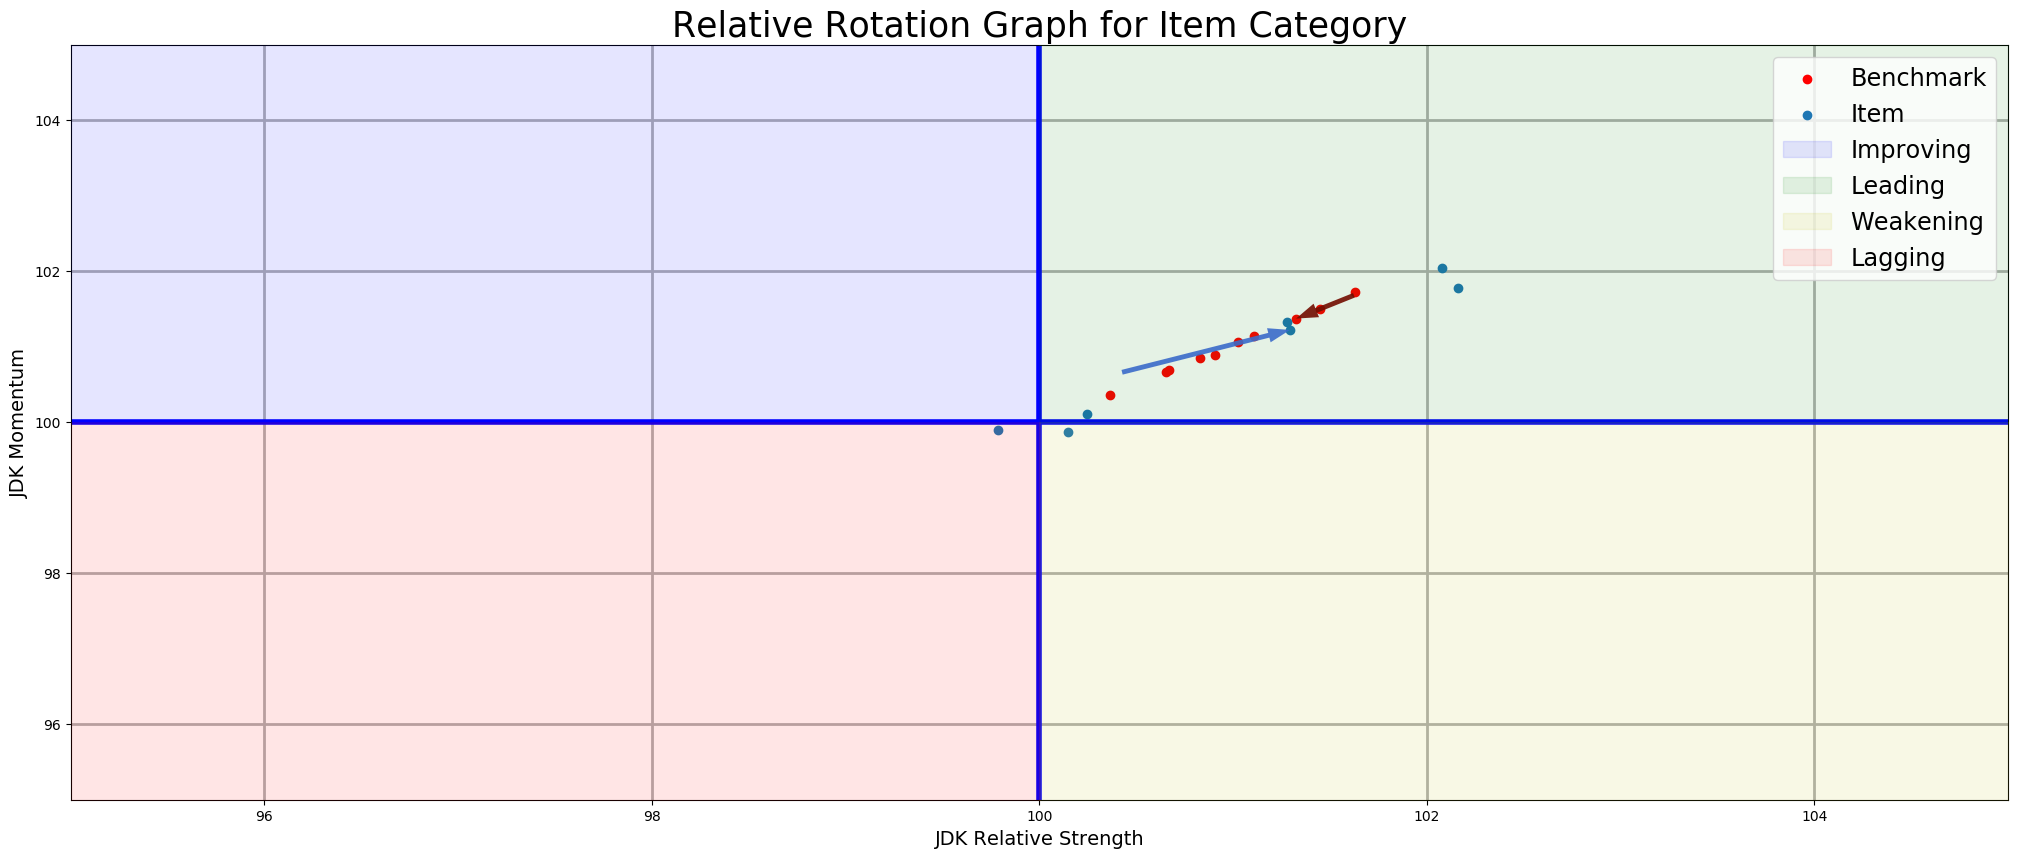

In [664]:
plot_RRG('FOODS_3_090_CA_3_validation', 350)

In the above example, we can see that this particular item is performing on par with its benchmark, although the direction that it's heading in is not ideal.

In [5]:
ca_short.head()

,id,d,sales,bollinger
24765098,HOBBIES_1_001_CA_1_validation,d_1201,0.0,0.0
24765099,HOBBIES_1_002_CA_1_validation,d_1201,0.0,0.0
24765100,HOBBIES_1_003_CA_1_validation,d_1201,0.0,0.0
24765101,HOBBIES_1_004_CA_1_validation,d_1201,2.0,2.0
24765102,HOBBIES_1_005_CA_1_validation,d_1201,2.0,2.0


Below is a similar function that generates two RRG features: 

1)'rrg_bench': identfies rotation position of the item specified relative to it's benchmark.

2)'rrg_item': identifies rotation position of item relative to its position n days ago.

In [8]:
#To save memory, we will generate category-based df's -that will be used in RRG - before we define the RRG function. 

food_benchmark = short.loc[short['cat']=='FOODS'].groupby('d')['bollinger'].mean().to_frame()
hobbies_benchmark = short.loc[short['cat']=='HOBBIES'].groupby('d')['bollinger'].mean().to_frame()
household_benchmark = short.loc[short['cat']=='HOUSEHOLD'].groupby('d')['bollinger'].mean().to_frame()

def RRG(item, window, steps):
    '''Relative Rotation Graph (RRG) of a sample of items and its categories. RRGs are made 
    of an item's/category's relative strength and momentum.
    
    Args:
        item(str): id of the item we are wanting to plot.
        window(int): window to to roll over.
        steps(int): number of days before next benchmark value is compared to item value. 
    
    Returns:
        RRG of item strength and momentum position compared to it's respective category. 
        This RRG takes advantage of a exponentially-weighted moving average.
    '''
    colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    categ = short.loc[short['id']==item]['cat'].iloc[0]
    if categ == 'FOODS':
        benchmark = food_benchmark
    elif categ == 'HOBBIES':
        benchmark = hobbies_benchmark
    else:
        benchmark = household_benchmark
    
    
    # Get the difference in price from previous step
    benchmark_delta = benchmark.diff().dropna()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences  
    benchmark_delta = benchmark_delta[1:]
    
    # Make the positive gains (up) and negative gains (down) Series
    b_up, b_down = benchmark_delta.copy(), benchmark_delta.copy()
    b_up[b_up < 0] = 0
    b_down[b_down > 0] = 0
    
    #Calculate EWMA for category series
    b_roll_up2 = b_up.ewm(window).mean()
    b_roll_down2 = b_down.abs().ewm(window).mean()  

    b_RS2 = b_roll_up2 / b_roll_down2
#     b_RSI2 = 100.0 - (100.0 / (1.0 + b_RS2))
    benchmark['jdk_rs'] = 100 + ((b_RS2 - b_RS2.mean()) / b_RS2.std() + 1)
    
    b_mom = benchmark.iloc[:,0].diff(periods = window).fillna(0)
    benchmark['jdk_mom'] = 100 + ((b_mom - b_mom.mean()) / b_mom.std() + 1)
    benchmark.fillna(0, inplace=True)
    
    #Repeat steps for the particular item we are indexing on
    series = short.loc[short['id'] == item]['bollinger'].to_frame()

    # Get the difference in price from previous step
    item_delta = series.diff().dropna()

    item_delta = item_delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    i_up, i_down = item_delta.copy(), item_delta.copy()
    i_up[i_up < 0] = 0
    i_down[i_down > 0] = 0

    # Calculate the EWMA for item series
    i_roll_up2 = i_up.ewm(window).mean()
    i_roll_down2 = i_down.abs().ewm(window).mean()
    
    # Calculate the RSI based on SMA
    i_RS2 = i_roll_up2 / i_roll_down2
    i_RS2.loc[i_RS2['bollinger']==np.inf, 'bollinger']=0
#     i_RSI2 = 100.0 - (100.0 / (1.0 + i_RS2))
    series['jdk_rs'] = 100 + ((i_RS2 - i_RS2.mean()) / i_RS2.std() + 1)

    i_mom = series.iloc[:,0].diff(periods = window).fillna(0)

    series['jdk_mom'] = 100 + ((i_mom - i_mom.mean()) / i_mom.std() + 1)
    series.fillna(0, inplace=True)

    #create points to compare of steps-day intervals
    ix = series.iloc[::steps]['jdk_rs'].values
    iy = series.iloc[::steps]["jdk_mom"].values
    item_vals = list(zip(ix,iy))
    
    bx = benchmark.iloc[::steps, benchmark.columns.get_loc("jdk_rs")].values
    by = benchmark.iloc[::steps, benchmark.columns.get_loc("jdk_mom")].values 
    bench_vals = list(zip(bx,by))
    
    
    from itertools import repeat
    
    rrg_bench = []
    rrg_item = []
     
    for i in range(len(item_vals)):
        if (item_vals[i][0]>bench_vals[i][0]) & (item_vals[i][1]>bench_vals[i][1]):
            rrg_bench.extend(repeat(1,steps))
        elif (item_vals[i][0]<bench_vals[i][0]) & (item_vals[i][1]>bench_vals[i][1]):
            rrg_bench.extend(repeat(2,steps))
        elif (item_vals[i][0]>bench_vals[i][0]) & (item_vals[i][1]<bench_vals[i][1]):
            rrg_bench.extend(repeat(3,steps))
        elif (item_vals[i][0]<bench_vals[i][0]) & (item_vals[i][1]<bench_vals[i][1]):
            rrg_bench.extend(repeat(4,steps))
        else:
            rrg_bench.extend(repeat(5,steps))
    
    for i in range(len(item_vals)):
        if (item_vals[i][0]>item_vals[i-1][0]) & (item_vals[i][1]>item_vals[i-1][1]):
            rrg_item.extend(repeat(1,steps))
        elif (item_vals[i][0]<item_vals[i-1][0]) & (item_vals[i][1]>item_vals[i-1][1]):
            rrg_item.extend(repeat(2,steps))
        elif (item_vals[i][0]>item_vals[i-1][0]) & (item_vals[i][1]<item_vals[i-1][1]):
            rrg_item.extend(repeat(3,steps))
        elif (item_vals[i][0]<item_vals[i-1][0]) & (item_vals[i][1]<item_vals[i-1][1]):
            rrg_item.extend(repeat(4,steps))
        else:
            rrg_item.extend(repeat(5,steps))
          
    series['rrg_bench'] = np.asarray(rrg_bench)
    series['rrg_item'] = np.asarray(rrg_item)
   
    return series['rrg_bench'], series['rrg_item']

When running the above function, an error was raised that stated that length of the series doesn't match the length of the df, which tells us that some of thats days from some of the items are missing. So, below, we will insert rows so that all items values have the same length so that the function can run through all of the items.

In [125]:
'''
In this cell we will be looking at the 'nonfit' df - a df of the items with missing days.
We will be checking which days are missing, and use the 'sales' df values to impute those days.
'''

for item in nonfit['id'].unique():
    nons = nonfit.loc[nonfit['id']==item, 'day'].unique()
    missing_days = [i for i in ca_short.iloc[:,-1].unique() if i not in nons]
    for day in missing_days:
        if (day+10) in ca_short.iloc[:,-1].unique():
            idx = (nonfit.loc[(nonfit['id']==item) & (nonfit['day'] == day+10)]).index + 1
            sales_val = sales.loc[(sales['id']==item)]['d_'+str(day)]
            row_vals = [item, 'd_'+str(day), sales_val,
                        nonfit.loc[(nonfit['id']==item) & (nonfit['day']) == day-1]['bollinger'],
                       nonfit.loc[(nonfit['id']==item)]['cat'],np.nan,np.nan,day]
            nonfit.loc[-1] = row_vals  # adding a row
            nonfit.index = nonfit.index + 1  # shifting index
        else:
            idx = (nonfit.loc[(nonfit['id']==item) & (nonfit['day'] == day-10)]).index + 1
            sales_val = sales.loc[(sales['id']==item)]['d_'+str(day)]
            row_vals = [item, 'd_'+str(day), sales_val,
                        nonfit.loc[(nonfit['id']==item) & (nonfit['day']) == day-1]['bollinger'],
                       nonfit.loc[(nonfit['id']==item)]['cat'],np.nan,np.nan,day]
            nonfit.loc[-1] = row_vals  # adding a row
            nonfit.index = nonfit.index + 1  # shifting index
nonfit = nonfit.sort_index()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\16507\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-125-ffe41980eb51>", line 11, in <module>
    nonfit.loc[-1] = row_vals  # adding a row
  File "C:\Users\16507\Anaconda3\lib\site-packages\pandas\core\indexing.py", line 190, in __setitem__
    self._setitem_with_indexer(indexer, value)
  File "C:\Users\16507\Anaconda3\lib\site-packages\pandas\core\indexing.py", line 449, in _setitem_with_indexer
    name=indexer)
  File "C:\Users\16507\Anaconda3\lib\site-packages\pandas\core\series.py", line 262, in __init__
    raise_cast_failure=True)
  File "C:\Users\16507\Anaconda3\lib\site-packages\pandas\core\internals\construction.py", line 615, in sanitize_array
    subarr = maybe_convert_platform(data)
  File "C:\Users\16507\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 39, in maybe_convert_platform
    values 

KeyboardInterrupt: 

In [ ]:
'''below are all of the lengths of the items(days) so that we can insert 'step' values in the RRG function.
By indexing on their divisors, we won't have to worry about the RRG series being of different length.'''

its = [741, 737, 730, 723,716,709,702,695,688,681,674,667,660,653,
       646,639,632,625,618,611,604,597,590,583,576,569,562,555,548,
       541,534,527,520,513,506,499,492,485,478, 471, 464,457,450,443,
      436, 429, 422,415, 408, 401, 394, 387, 380, 373, 366]

divis = {}

for i in its:
    d = []
    for x in range(1,i):
        if i%x==0:
            d.append(x)
            divis[i]=d

In [28]:
epic = True
while epic==True:
    for item in ca_short['id'].unique():
        for key, val in divis.items():
            if len(ca_short.loc[ca_short['id']==item])==key:
                if len(val)>1:
                    if val[int(np.floor(len(val)*0.4))]>=35:
                        step = val[int(np.floor(len(val)*0.4)-1)]
                        ca_short.loc[ca_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                        ca_short.loc[ca_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
                    else:
                        step = val[int(np.floor(len(val)*0.4))]
                        ca_short.loc[ca_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                        ca_short.loc[ca_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
                else: 
                    step = val[0]
                    ca_short.loc[ca_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                    ca_short.loc[ca_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
    epic = False

In [79]:
ca_short.to_pickle('ca_rrg.pkl')

In [36]:
tx_len = []
for i in tx_short['id'].unique():
    item_len = len(tx_short.loc[tx_short['id']==i])
    if item_len not in tx_len:
        tx_len.append(item_len)
    else:
        continue

In [41]:
'''Let's gather all of the lengths from the TX dataframe.'''

only_tx =[i for i in tx_len if i not in its]
tx_divisors = {}
    
for lgth in only_tx:
    divs = []
    for x in range(1, lgth):
        if lgth%x==0:
            divs.append(x)
    tx_divisors[lgth] = divs

divis = {**divis, **tx_divisors}

{741: [1, 3, 13, 19, 39, 57, 247],
 737: [1, 11, 67],
 730: [1, 2, 5, 10, 73, 146, 365],
 723: [1, 3, 241],
 716: [1, 2, 4, 179, 358],
 709: [1],
 702: [1, 2, 3, 6, 9, 13, 18, 26, 27, 39, 54, 78, 117, 234, 351],
 695: [1, 5, 139],
 688: [1, 2, 4, 8, 16, 43, 86, 172, 344],
 681: [1, 3, 227],
 674: [1, 2, 337],
 667: [1, 23, 29],
 660: [1,
  2,
  3,
  4,
  5,
  6,
  10,
  11,
  12,
  15,
  20,
  22,
  30,
  33,
  44,
  55,
  60,
  66,
  110,
  132,
  165,
  220,
  330],
 653: [1],
 646: [1, 2, 17, 19, 34, 38, 323],
 639: [1, 3, 9, 71, 213],
 632: [1, 2, 4, 8, 79, 158, 316],
 625: [1, 5, 25, 125],
 618: [1, 2, 3, 6, 103, 206, 309],
 611: [1, 13, 47],
 604: [1, 2, 4, 151, 302],
 597: [1, 3, 199],
 590: [1, 2, 5, 10, 59, 118, 295],
 583: [1, 11, 53],
 576: [1,
  2,
  3,
  4,
  6,
  8,
  9,
  12,
  16,
  18,
  24,
  32,
  36,
  48,
  64,
  72,
  96,
  144,
  192,
  288],
 569: [1],
 562: [1, 2, 281],
 555: [1, 3, 5, 15, 37, 111, 185],
 548: [1, 2, 4, 137, 274],
 541: [1],
 534: [1, 2, 3, 6, 

In [44]:
epic1 = True
while epic1==True:
    for item in tx_short['id'].unique():
        for key, val in divis.items():
            if len(tx_short.loc[tx_short['id']==item])==key:
                if len(val)>3:
                    if val[int(np.floor(len(val)*0.4))]>=35:
                        step = val[int(np.floor(len(val)*0.4)-1)]
                        tx_short.loc[tx_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                        tx_short.loc[tx_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
                    else:
                        step = val[int(np.floor(len(val)*0.4))]
                        tx_short.loc[tx_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                        tx_short.loc[tx_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
                else: 
                    step = val[-1]
                    tx_short.loc[tx_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                    tx_short.loc[tx_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
    epic1 = False

KeyboardInterrupt: 

In [72]:
tx_short.to_pickle('tx_rrg.pkl')

In [47]:
wi_len = []
for i in wi_short['id'].unique():
    item_len = len(wi_short.loc[wi_short['id']==i])
    if item_len not in wi_len:
        wi_len.append(item_len)
    else:
        continue

In [57]:
'''Let's gather all of the lengths from the WI dataframe.'''

only_wi =[i for i in wi_len if i not in divis.keys()]
wi_divisors = {}
    
for lgth in only_wi:
    divs = []
    for x in range(1, lgth):
        if lgth%x==0:
            divs.append(x)
    wi_divisors[lgth] = divs

divis = {**divis, **wi_divisors}

In [58]:
epic2 = True
while epic2==True:
    for item in wi_short['id'].unique():
        for key, val in divis.items():
            if len(wi_short.loc[wi_short['id']==item])==key:
                if len(val)>3:
                    if val[int(np.floor(len(val)*0.6))]>=35:
                        step = val[int(np.floor(len(val)*0.4)-1)]
                        wi_short.loc[wi_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                        wi_short.loc[wi_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
                    else:
                        step = val[int(np.floor(len(val)*0.6))]
                        wi_short.loc[wi_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                        wi_short.loc[wi_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
                else: 
                    step = val[-1]
                    wi_short.loc[wi_short['id']==item, 'rrg_bench'] = RRG(item,90,step)[0]
                    wi_short.loc[wi_short['id']==item, 'rrg_item'] = RRG(item,90,step)[1]
    epic2 = False

KeyboardInterrupt: 

In [80]:
wi_short.to_pickle('wi_rrg.pkl')

Below we will add an Average True Range (ATR) feature. This feature measures the trendiness of the data; the higher the ATR value, the more the item sales are trending in either direction.

Text(0.5, 1.0, 'HOBBIES_1_004_CA_1_validation Average True Range (ATR)')

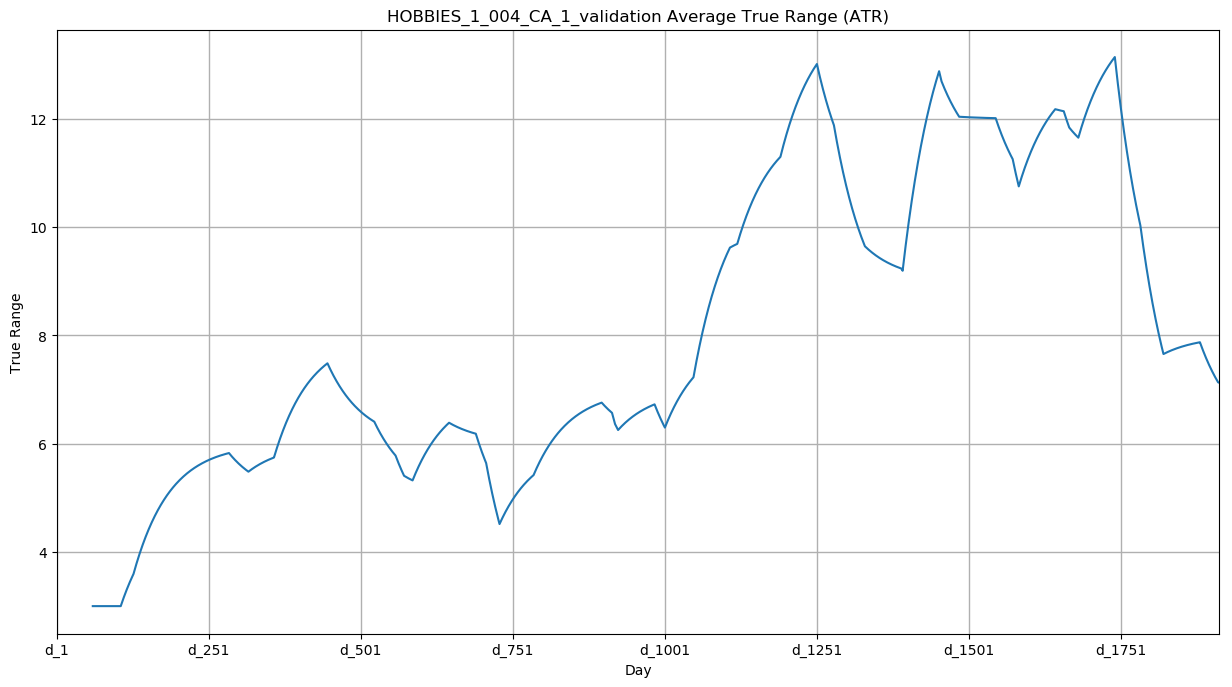

In [12]:
#Volatility measure
def wwma(values, window):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/window, adjust=False).mean()

def ATR(item, window):
    
    item_df = sales.loc[sales['id'] == item][d_cols]
    item_wwma = item_df.ewm(alpha=1/window, adjust=False).mean() #Wilder's EMA
        
    high = item_df.rolling(window).max()
    low = item_df.rolling(window).min()
    close = item_df.rolling(window).mean()
    item_df['tr0'] = abs(high - low)
    item_df['tr1'] = abs(high - close.shift())
    item_df['tr2'] = abs(low - close.shift())
    tr = item_df[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, window)
    short['atr'] = atr
    return short['atr']
    



item = 'HOBBIES_1_004_CA_1_validation'

item_atr = ATR(item, 60)

fig, axes = plt.subplots(1,1, figsize=(15,8), dpi=100)
item_atr.plot()
axes.grid(linestyle='-', linewidth='1.0')
plt.xlabel('Day')
plt.ylabel('True Range')
plt.title('%s Average True Range (ATR)'% item)

In [116]:
#Volatility measure
def wwma(values, window):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/window, adjust=False).mean()

def ATR(item, window):
    
    item_df = pd.DataFrame({'bollinger':short.loc[short['id'] == item]['bollinger']})
    item_wwma = item_df.ewm(alpha=1/window, adjust=False).mean() #Wilder's EMA
    
    high = item_df.rolling(window).max()
    low = item_df.rolling(window).min()
    close = item_df.rolling(window).mean()
    item_df['tr0'] = abs(high - low)
    item_df['tr1'] = abs(high - close.shift())
    item_df['tr2'] = abs(low - close.shift())
    tr = item_df[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, window)
    short['atr'] = atr
    return short['atr'].fillna(method='ffill')

In [124]:
at = True
while at==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==item, 'ATR'] = ATR(item, 90)
    at=False

In [125]:
ca_short.ATR.fillna(method='bfill', inplace=True)
ca_short.head()

,id,d,sales,bollinger,cat,rrg_bench,rrg_item,ATR
24765098,HOBBIES_1_001_CA_1_validation,d_1201,0.0,0.0,HOBBIES,5.0,5.0,3.0
24765099,HOBBIES_1_002_CA_1_validation,d_1201,0.0,0.0,HOBBIES,5.0,5.0,3.0
24765100,HOBBIES_1_003_CA_1_validation,d_1201,0.0,0.0,HOBBIES,5.0,5.0,3.0
24765101,HOBBIES_1_004_CA_1_validation,d_1201,2.0,2.0,HOBBIES,5.0,5.0,3.0
24765102,HOBBIES_1_005_CA_1_validation,d_1201,2.0,2.0,HOBBIES,5.0,5.0,3.0


In [127]:
ca_short.to_pickle('ca_atr.pkl')

In [128]:
at1 = True
while at1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==item, 'ATR'] = ATR(item, 90)
    at1=False

In [129]:
tx_short.ATR.fillna(method='bfill', inplace=True)

In [130]:
tx_short.to_pickle('tx_atr.pkl')

In [131]:
at2 = True
while at2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==item, 'ATR'] = ATR(item, 90)
    at2=False

In [132]:
wi_short.ATR.fillna(method='bfill', inplace=True)

In [133]:
wi_short.to_pickle('wi_atr.pkl')

Below is annualized volatility - a popular metric used in finance.

In [154]:
def annualized_volatility(item, window):
    "Return the annualized standard deviation of daily log returns of item."
    
    item_df = pd.DataFrame({'bollinger':short.loc[short['id'] == item]['bollinger']})
    item_df['ann_vol'] = item_df.diff().rolling(window).std()*(365**0.5)
    return item_df['ann_vol']

item_ann = annualized_volatility(item, 30)

fig, axes = plt.subplots(1,1, figsize=(15,8), dpi=100)
item_ann.plot(ax=axes)
axes.grid(linestyle='-', linewidth='1.0')
plt.xlabel('Day')
plt.ylabel('Volatility')
plt.title('%s Annualized Volatility'% item)
plt.legend(item)
plt.show()

In [155]:
av = True
while av==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==item, 'ann_vol'] = annualized_volatility(item, 35)
    av=False

In [173]:
ca_short.to_pickle('ca_ann_vol.pkl')

In [162]:
av1 = True
while av1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==item, 'ann_vol'] = annualized_volatility(item, 35)
    av1=False

In [176]:
tx_short.to_pickle('tx_ann_vol.pkl')

In [177]:
av2 = True
while av2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==item, 'ann_vol'] = annualized_volatility(item, 35)
    av2=False

In [178]:
wi_short.ann_vol.fillna(method='bfill',inplace=True)
wi_short.ann_vol.fillna(0,inplace=True)
wi_short.ann_vol.isna().sum()

0

In [179]:
wi_short.to_pickle('wi_ann_vol.pkl')

We can create a entropy feature below to measure the disorder in the sales values.

In [258]:
short['bollinger'].fillna(method='ffill', inplace=True)
short.bollinger.isna().sum()

0

In [259]:
import math
def calc_entropy(column):
    """
    Calculate entropy given a pandas series, list, or numpy array.
    """
    column = pd.DataFrame({'bollinger':short.loc[short['id'] == item]['bollinger']})
    column = np.squeeze(column)
    # Compute the counts of each unique value in the column
    counts = np.bincount(column)
    # Divide by the total column length to get a probability
    probabilities = counts / len(column)
    
    # Initialize the entropy to 0
    entropy = 0
    # Loop through the probabilities, and add each one to the total entropy
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)
    
    return -entropy

In [261]:
ent = True
while ent==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==item, 'entropy'] = calc_entropy(item)
    ent=False

In [262]:
ca_short.entropy.isna().sum()

0

In [263]:
ca_short.to_pickle('ca_entropy.pkl')

In [264]:
ent1 = True
while ent1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==item, 'entropy'] = calc_entropy(item)
    ent1=False

In [265]:
tx_short.entropy.isna().sum()

0

In [266]:
tx_short.to_pickle('tx_entropy.pkl')

In [267]:
ent2 = True
while ent2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==item, 'entropy'] = calc_entropy(item)
    ent2=False

In [268]:
wi_short.entropy.isna().sum()

0

In [269]:
wi_short.to_pickle('wi_entropy.pkl')

We can create item beta - the amount of sales volatility the items has compared to its category benchmark.

In [331]:
def beta(item, window):
    categ = short.loc[short['id']==item]['cat'].iloc[0]
    if categ == 'FOODS':
        benchmark = food_benchmark.iloc[:,0]
    elif categ == 'HOBBIES':
        benchmark = hobbies_benchmark.iloc[:,0]
    else:
        benchmark = household_benchmark.iloc[:,0]
    
    series = short.loc[short['id'] == item]['bollinger'].to_frame()
    benchmark = benchmark[:len(series)]
    
    series_roll = np.squeeze(series.rolling(window).std())
    bench_roll = benchmark.rolling(window).std()
    series_roll.fillna(0, inplace=True)
    bench_roll.fillna(0,inplace=True)
    
    beta = series_roll.values/bench_roll.values

    series['beta'] = beta
    series['beta'].fillna(0, inplace=True)
    return series['beta']

In [332]:
bet = True
while bet==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==item, 'beta'] = beta(item, 60)
    bet=False

In [333]:
ca_short.beta.isna().sum()

0

In [334]:
ca_short.to_pickle('ca_beta.pkl')

In [335]:
bet1 = True
while bet1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==item, 'beta'] = beta(item, 60)
    bet1=False

In [336]:
tx_short.beta.isna().sum()

0

In [337]:
tx_short.to_pickle('tx_beta.pkl')

In [338]:
bet2 = True
while bet2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==item, 'beta'] = beta(item, 60)
    bet2=False

In [339]:
wi_short.beta.isna().sum()

0

In [340]:
wi_short.to_pickle('wi_beta.pkl')

Information ratio cal help us measure the amount of returns generated for a certain amount of volatility the item assumes.

In [342]:
def information_ratio(item, window):
    categ = short.loc[short['id']==item]['cat'].iloc[0]
    if categ == 'FOODS':
        benchmark = food_benchmark.iloc[:,0]
    elif categ == 'HOBBIES':
        benchmark = hobbies_benchmark.iloc[:,0]
    else:
        benchmark = household_benchmark.iloc[:,0]
    
    series = short.loc[short['id'] == item]['bollinger'].to_frame()
    benchmark = benchmark[:len(series)]
    
    return_difference = series.values - benchmark.values
    volatility = return_difference.std() * np.sqrt(window) 
    information_ratio = return_difference.mean() / volatility
    
    series['info_ratio'] = information_ratio
    
    return series['info_ratio']

In [344]:
ir = True
while ir==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==item, 'info_ratio'] = information_ratio(item, 365)
    ir=False

In [345]:
ca_short.info_ratio.isna().sum()

0

In [347]:
ca_short.to_pickle('ca_ir.pkl')

In [348]:
ir1 = True
while ir1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==item, 'info_ratio'] = information_ratio(item, 250)
    ir1=False

In [349]:
tx_short.info_ratio.isna().sum()

0

In [350]:
tx_short.to_pickle('tx_ir.pkl')

In [352]:
ir2 = True
while ir2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==item, 'info_ratio'] = information_ratio(item, 365)
    ir2=False

In [353]:
wi_short.info_ratio.isna().sum()

0

In [354]:
wi_short.to_pickle('wi_ir.pkl')

In [9]:
ca_short = pd.read_pickle('ca_ir.pkl')
tx_short = pd.read_pickle('tx_ir.pkl')
wi_short = pd.read_pickle('wi_ir.pkl')

Triple Exponential Moving Average (TEMA) may be appropriate give the large timespan of the data.

In [11]:
def EMA(item, window, adjust = True):
        """
        Exponential Weighted Moving Average - Like all moving average indicators, they are much better suited for trending markets.
        When the market is in a strong and sustained uptrend, the EMA indicator line will also show an uptrend and vice-versa for a down trend.
        EMAs are commonly used in conjunction with other indicators to confirm significant market moves and to gauge their validity.
        """
        
        item_df = series = short.loc[short['id'] == item]['bollinger'].to_frame()
        return pd.Series(
            item_df.iloc[:,0]
            .ewm(span=window, adjust=adjust)
            .mean(),
            name="{0} period EMA".format(window),
        )

def TEMA(item, window, adjust = True):
        """
        Triple exponential moving average - attempts to remove the inherent lag associated to Moving Averages by placing more weight on recent values.
        The name suggests this is achieved by applying a triple exponential smoothing which is not the case. The name triple comes from the fact that the
        value of an EMA (Exponential Moving Average) is triple.
        To keep it in line with the actual data and to remove the lag the value 'EMA of EMA' is subtracted 3 times from the previously tripled EMA.
        Finally 'EMA of EMA of EMA' is added.
        Because EMA(EMA(EMA)) is used in the calculation, TEMA needs 3 * period - 2 samples to start producing values in contrast to the period samples
        needed by a regular EMA.
        """
        item_df = short.loc[short['id'] == item]['bollinger'].to_frame()
        triple_ema = 3 * EMA(item, window)
        ema_ema_ema = (
            EMA(item, window)
            .ewm(ignore_na=False, span=window, adjust=adjust)
            .mean()
            .ewm(ignore_na=False, span=window, adjust=adjust)
            .mean()
        )

        TEMA = (
            triple_ema
            - 3
            * EMA(item, window)
            .ewm(span=window, adjust=adjust)
            .mean()
            + ema_ema_ema
        )

        return pd.Series(TEMA, name="{0} period TEMA".format(window))

In [12]:
trip = True
while trip==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==item, 'triple_exp'] = TEMA(item, 90)
    trip=False

In [13]:
ca_short.triple_exp.isna().sum()

0

In [14]:
ca_short.to_pickle('ca_tema.pkl')

In [15]:
trip1 = True
while trip1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==item, 'triple_exp'] = TEMA(item, 90)
    trip1=False

In [16]:
tx_short.triple_exp.isna().sum()

0

In [17]:
tx_short.to_pickle('tx_tema.pkl')

In [18]:
trip2 = True
while trip2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==item, 'triple_exp'] = TEMA(item, 90)
    trip2=False

In [19]:
wi_short.triple_exp.isna().sum()

0

In [20]:
wi_short.to_pickle('wi_tema.pkl')

Let's now generate relative_volatility metric for each item.

In [33]:
def relative_volatility(item, w1, w2):
    series = short.loc[short['id'] == item]['bollinger'].to_frame()
    r1 = series.rolling(w1).std()
    r2 = series.rolling(w2).std()
    r1 = r1.shift(w2)
    r2 = r2.shift(-w1)

    rv =r1/r2
    series['rv'] = rv
    return series['rv']

In [34]:
rel = True
while rel==True:
    for item in ca_short['id'].unique():
        ca_short.loc[ca_short['id']==item, 'relative_vol'] = relative_volatility(item, 90,180)
    rel=False

In [35]:
ca_short.relative_vol.isna().sum()

4427602

In [36]:
ca_short.relative_vol.fillna(0, inplace=True)

In [37]:
ca_short.to_pickle('ca_rv.pkl')

In [38]:
rel1 = True
while rel1==True:
    for item in tx_short['id'].unique():
        tx_short.loc[tx_short['id']==item, 'relative_vol'] = relative_volatility(item, 90,180)
    rel1=False

In [40]:
tx_short.relative_vol.isna().sum()

3335576

In [41]:
tx_short.relative_vol.fillna(0, inplace=True)

In [42]:
tx_short.to_pickle('tx_rv.pkl')

In [43]:
rel2 = True
while rel2==True:
    for item in wi_short['id'].unique():
        wi_short.loc[wi_short['id']==item, 'relative_vol'] = relative_volatility(item, 90,180)
    rel2=False

In [44]:
wi_short.relative_vol.fillna(0, inplace=True)

In [45]:
wi_short.relative_vol.isna().sum()

0

In [46]:
wi_short.to_pickle('wi_rv.pkl')